# Machine Learning and Predictive Analytics

According to the nature of the project's goal (classify transactions into binary groups), in this notebook we will be training some classification machine learning algorithms with our processed data to try to classify fraudulent transactions with the best precision possible. We will firt make some transformations to the data so that it fits the models and then we will train them and evaluate their performance.

# Index

In this notebook, we will train the data (*transactions_processed.csv*) and evaluate the performance of different models. The steps that we will follow are:

1. **Import Libraries**
2. **Data Transformation**
    - **2.1 Handle missing values and outliers**
    - **2.2 Discretize variables**
    - **2.3 Normalize variables**  
    - **2.4 Split the data**
    - **2.5 Encode variables**  
    - **2.6 Sample the data**
    - **2.7 Evaluate Sampling Techniques**
3. **Model Training and Evaluation**
4. **Auto ML with PyCaret**
5. **Test Neuronal Networks with TensorFlow (Extra)**    
6. **Conclusion**



## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from scipy.stats import boxcox, probplot
import random


# Data Sampling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks, NearMiss, RandomUnderSampler, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as imbPipeline



# Machine Learning
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# AutoML
from pycaret.classification import *


# Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# read the data
os.chdir('..')

path = os.getcwd()+'/data/transactions_processed.csv'
df = pd.read_csv(path, encoding='latin1')

df.head()

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Device Used,Is Fraudulent,Account Age Days,Transaction Hour,Shipping Billing Same
0,58.09,bank transfer,electronics,1,17,tablet,0,30,5,1
1,389.96,debit card,electronics,2,40,desktop,0,72,8,1
2,134.19,PayPal,home & garden,2,22,tablet,0,63,3,1
3,226.17,bank transfer,clothing,5,31,desktop,0,124,20,1
4,121.53,bank transfer,clothing,2,51,tablet,0,158,5,1


## 2. Data Transformation

### 2.1 Handle missing values and outliers
As we mentioned in the preprocessing, we didn't want to remove 'Transaction Amount' outliers because they could be important for the model and, indeed, we saw during the EDA that big amount transactions were related with fraudulence. However, we will remove the outliers from 'Customers Age' since they present negative values and there is not such relation with the target variable. We use the IQR method to remove the outliers.

In [3]:
# calculate Q1, Q3, and IQR for Customer Age
Q1 = df['Customer Age'].quantile(0.25)
Q3 = df['Customer Age'].quantile(0.75)
IQR = Q3 - Q1

# define the lower and upper bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# identify the outliers
outliers = (df['Customer Age'] < lower_bound) | (df['Customer Age'] > upper_bound)
print(f'Outliers in Customer Age: {outliers.sum()}')

# handle outliers by capping them to the lower and upper bounds
df['Customer Age'] = df['Customer Age'].clip(lower_bound, upper_bound)


Outliers in Customer Age: 13746


### 2.2 Discretize variables
We discretize the relevant continuous variables. This improves model interpretability: grouping continuous variables into categories (e.g., '<1 month', 'Morning') makes the model's predictions easier to understand and interpret and helps capture non-linear relationships within the data.

In [4]:
# define bins and labels for Account Age Days
account_age_bins = [0, 30, 90, 180, 366]
account_age_labels = ['1-3 months', '3-6 months', '6-9 months' ,'6-12 months']

# create new column with the binned data for Account Age Days and drop the original column
df['Account Age Range'] = pd.cut(df['Account Age Days'], bins=account_age_bins, labels=account_age_labels, right=False)
df.drop('Account Age Days', axis=1, inplace=True)

# define bins and labels for Transaction Hour and drop the original column
transaction_hour_bins = [0, 6, 12, 18, 24]
transaction_hour_labels = ['Dawn', 'Morning', 'Afternoon', 'Evening']

# create new column with the binned data for Transaction Hour
df['Transaction Hour Range'] = pd.cut(df['Transaction Hour'], bins=transaction_hour_bins, labels=transaction_hour_labels, right=False)
df.drop('Transaction Hour', axis=1, inplace=True)

# define bins and labels for Customer Age (in bins of 10 years) and drop the original column
customer_age_bins = range(0, 71, 10)
customer_age_labels = [f'{i}-{i+9}' for i in range(0, 70, 10)]

# create new column with the binned data for Customer Age
df['Customer Age Range'] = pd.cut(df['Customer Age'], bins=customer_age_bins, labels=customer_age_labels, right=False)
df.drop('Customer Age', axis=1, inplace=True)

# display the first few rows to check the new columns
df.head()

,Transaction Amount,Payment Method,Product Category,Quantity,Device Used,Is Fraudulent,Shipping Billing Same,Account Age Range,Transaction Hour Range,Customer Age Range
0,58.09,bank transfer,electronics,1,tablet,0,1,3-6 months,Dawn,10-19
1,389.96,debit card,electronics,2,desktop,0,1,3-6 months,Morning,40-49
2,134.19,PayPal,home & garden,2,tablet,0,1,3-6 months,Dawn,20-29
3,226.17,bank transfer,clothing,5,desktop,0,1,6-9 months,Evening,30-39
4,121.53,bank transfer,clothing,2,tablet,0,1,6-9 months,Dawn,50-59


### 2.3 Normalize variables:  
We saw in the EDA that 'Transaction Amount' variable was higly right skewed. Since the models tipically work better with normally distributed data, we use Box-Cox transformation to normalize it.

Lambda used for Box-Cox transformation: 0.09471331898929042


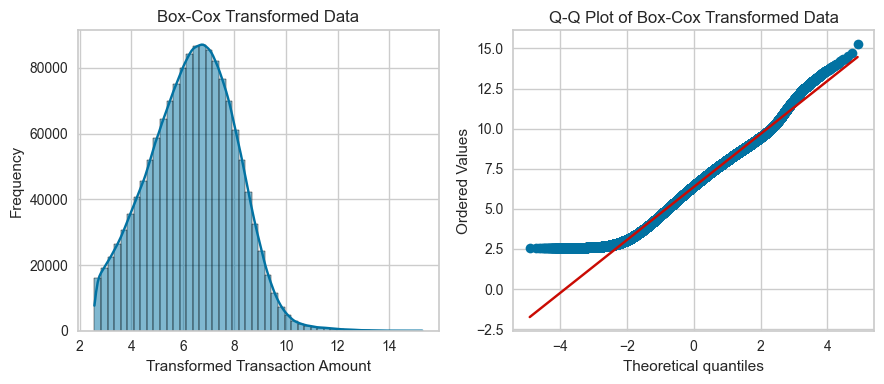

In [5]:
# apply Box-Cox transformation to the Transaction Amount
_ , lam = boxcox(df['Transaction Amount'])
print(f"Lambda used for Box-Cox transformation: {lam}")

# create a histogram and Q-Q plot to check the distribution of the transformed data
plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
sns.histplot(_, bins=50, kde=True)
plt.title('Box-Cox Transformed Data')
plt.xlabel('Transformed Transaction Amount')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
probplot(_, dist="norm", plot=plt)
plt.title('Q-Q Plot of Box-Cox Transformed Data')

plt.tight_layout()

# save the graph as an PNG file for later use in Streamlit
dir_path = 'graphs/ML'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
plt.savefig(f"{dir_path}/box_cox_transformed.png")
plt.show()

### 2.4 Split the data
We divide the data into training and testing sets. The training set is used to train the model, while the testing set is used to evaluate the model's performance on unseen data. We use the train_test_split method from the sklearn library to split the data. We will use 80% of the data for training and 20% for testing. We also set a random seed (random_state) to ensure reproducibility.

In [6]:
# set seed
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True

In [7]:
# apply the seed to everything
seed_everything(42)

# define the features and target variable.
X= df.drop(['Is Fraudulent'], axis=1)
y = df['Is Fraudulent']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) 
    
    # stratify=y ensures that the proportion of fraudulent transactions is the same in both sets.

# reset the indices of the training and testing sets
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

### 2.5 Encode variables:  
We encode the categorical variables using the OneHotEncoder method from the sklearn library. This is necessary because most machine learning algorithms work only with numerical data. Encoding helps us represent these variables in a way that preserves their meaning and relationships, improving the model's performance and accuracy. We also apply the box-cox transformation (defined previously) to the 'Transaction Amount' variable.

In [8]:
# encode the categorical columns

# define the columns to be encoded
categorical_columns = ['Payment Method', 'Product Category', 'Device Used', 'Account Age Range', 'Transaction Hour Range', 'Customer Age Range']

# define the lambda function for Box-Cox transformation
def boxcox_transform(X, lmbda):
    return boxcox(X, lmbda=lmbda)

# create the encoder with OneHotEncoder and FunctionTransformer
column_transformer = ColumnTransformer(
    transformers=[
        ('categoric', OneHotEncoder(handle_unknown='ignore'), categorical_columns), # apply OneHotEncoder to the categorical columns        
        ('boxcox', FunctionTransformer(boxcox_transform, kw_args={'lmbda': lam}), ['Transaction Amount']) # call the Box Cox function defined earlier with the lambda value
    ],
    remainder='passthrough' # the remaining columns are not transformed
)

# data transformation
column_transformer = column_transformer.fit(X_train)
X_train = column_transformer.transform(X_train)
X_test = column_transformer.transform(X_test)

# save the transformer for future use in case we need to transform new data for another model
dir_path = 'src/models'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
joblib.dump(column_transformer, os.path.join(dir_path, 'column_transformer.joblib'))

['src/models\\column_transformer.joblib']

### 2.6 Sample the data
The dataset is clearly unbalanced, this is, the proportion of fraudulent transactions is really low. Models trained on unbalanced data tend to be biased towards the majority class, resulting in poor performance on the minority class (fraudulent transactions). By altering the proportion of fraudulent transactions, we can ensure that the model pays adequate attention to both classes, thereby improving its ability to detect fraud. We will apply two techniques to address this issue: 
- First, we will change the proportion of fraudulent transactions by fractioning the data. For this purpose, we will remove the 90% of the legitimate transactions applying a method for calculating the distances between the central value of the fraudulent transactions and the rest of the points. Then we calculate the percentiles of the distances and remove randomly the 90% of the points.
- After this, we will further balance the data by evaluating different sampling techniques and keeping the best one.

Data before sampling: (1472952, 10)
Data after sampling: (170990, 30)


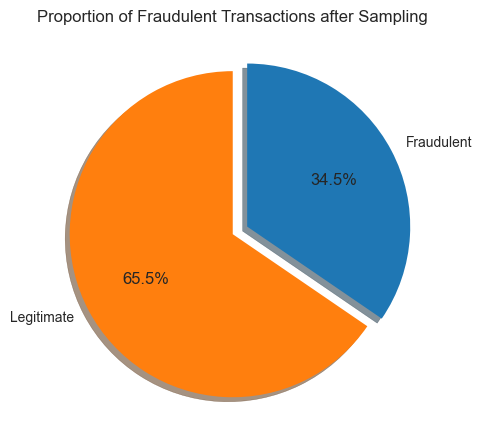

In [9]:
# data before sampling
print('Data before sampling:', df.shape)

# convert the transformed data back to a DataFrame
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# separate the fraudulent and legitimate transactions
X_train_0 =  X_train[y_train == 0] # legitimate transactions
X_train_1 =  X_train[y_train == 1] # fraudulent transactions

# calculate the central value of the fraudulent transactions
central_X1 = X_train_1.mean(axis=0) # calculate the mean of the fraudulent transactions

# calculate the distance from the central value of X_train_1 to all the points in X_train_0 using broadcasting
distances = np.linalg.norm(X_train_0 - central_X1, axis=1) # calculate the Euclidean distance

# calculate the percentiles of the distances(split the distances into 10 groups of equal size)
percentiles = np.percentile(distances, np.linspace(0, 100, 11))

# we remove from each percentile the 90% of the points in X_train_0 (this will change the proportion of fraudulent transactions):

# create a mask to filter out 90% of the points in each percentile group (np.digitize would do the same job)
mask = np.zeros(len(X_train_0), dtype=bool)

for i in range(len(percentiles) - 1):
    lower_bound = percentiles[i] # lower bound of the percentile
    upper_bound = percentiles[i + 1] # upper bound of the percentile
    in_percentile = (distances >= lower_bound) & (distances < upper_bound) # filter the points in X_train_0 that fall within the current percentile range of distances
    indices = np.where(in_percentile)[0]  # get the indices of the points
    np.random.shuffle(indices) # shuffle the indices
    keep_indices = indices[:int(0.1 * len(indices))] # Keep 10% of the indices
    mask[keep_indices] = True # update the mask to keep the selected points

# apply the mask to X_train_0 to keep only 10% of the points in each percentile group
X_train_0_sampled = X_train_0[mask]

# combine the sampled legitimate transactions with the fraudulent transactions into a DataFrame
X_train_balanced = pd.concat([X_train_0_sampled, X_train_1])

# data after sampling
print('Data after sampling:', X_train_balanced.shape)

# balance the target variable for the train data
y_train_balanced = y_train[X_train.index.isin(X_train_balanced.index)]

# combine the balanced features with the target variable
df_balanced = pd.concat([X_train_balanced, y_train_balanced], axis=1)

# show the new distribution of the target variable
plt.figure(figsize=(5, 5))
fig = plt.pie(df_balanced['Is Fraudulent'].value_counts(), labels=['Legitimate', 'Fraudulent'], autopct='%1.1f%%', startangle=90, colors=['#FF7F0E', '#1F77B4'], explode=(0, 0.1), shadow=True)
plt.tight_layout()
plt.title('Proportion of Fraudulent Transactions after Sampling')

# save the graph as an PNG file for later use in Streamlit
dir_path = 'graphs/ML'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
plt.savefig(f"{dir_path}/target_variable_pie_chart.png")
plt.show()

### 2.7 Evaluate sampling techniques
We define a function that will evaluate different sampling techniques to balance the data and will use the one that provides the best performance to replace the original x_train and y_train with the balanced data.

Best result based on F1 score:
Method           NearMiss
Type        Undersampling
ROC AUC          0.555916
Accuracy         0.523916
F1               0.110766
Recall           0.591482
Name: 5, dtype: object
              Method           Type   ROC AUC  Accuracy        F1    Recall
0               None           None  0.500000  0.949869  0.000000  0.000000
1              SMOTE   Oversampling  0.522937  0.415936  0.099247  0.641861
2             ADASYN   Oversampling  0.506133  0.278430  0.095425  0.759209
3  RandomOverSampler   Oversampling  0.526248  0.494849  0.100213  0.561146
4         TomekLinks  Undersampling  0.500000  0.949869  0.000000  0.000000


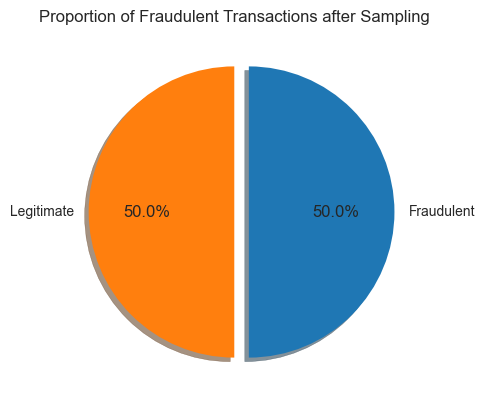

In [10]:
# define the function to evaluate the sampling techniques
def evaluate_sampling_techniques(X_test, y_test, X_train, y_train):

    '''
    We define a function that evaluates different sampling techniques for a binary classification model using logistic regression 
    due to its simplicity, interpretability, and computational efficiency. The model returns a DataFrame with the obtained results. 
    It includes oversampling, undersampling, and combinations techniques, and identifies the best result based on the F1 score.

    Parameters:
    - X_test: Features of the testing set.
    - y_test: Target variable of the testing set.
    - X_train: Features of the training set.
    - y_train: Target variable of the training set.
    - column_transformer: Transformer for preprocessing the features.

    Samplings Techniques:
    - Oversampling: SMOTE, ADASYN, RandomOverSampler.
    - Undersampling: TomekLinks, NearMiss, RandomUnderSampler, EditedNearestNeighbours.
    - Combine-sampling: SMOTETomek, SMOTEENN.

    Steps:
    1. Define the logistic regression model.
    2. Define oversampling, undersampling, and combination techniques.
    3. Evaluate each technique individually.
    4. Collect metrics (ROC AUC, accuracy, F1 score, recall) for each method.
    5. Identify and print the best result based on the F1 score.
    6. Return the transformed X_train ,X_test , y_train , y_test using the best sampling technique.
    '''

    # define the model
    model = LogisticRegression(solver='liblinear')

    # define oversampling techniques
    over_sampling_methods = {
        'SMOTE': SMOTE(),
        'ADASYN': ADASYN(),
        'RandomOverSampler': RandomOverSampler()
    }

    # define undersampling techniques
    under_sampling_methods = {
        'TomekLinks': TomekLinks(),
        'NearMiss': NearMiss(),
        'RandomUnderSampler': RandomUnderSampler(),
        'EditedNearestNeighbour': EditedNearestNeighbours(n_neighbors=3)
    }

    # define combine-sampling techniques
    combine_sampling_methods = {
        'SMOTETomek': SMOTETomek(smote=SMOTE(sampling_strategy='minority'), tomek=TomekLinks(sampling_strategy='majority')),
        'SMOTEENN': SMOTEENN(smote=SMOTE(sampling_strategy='minority'), enn=EditedNearestNeighbours(sampling_strategy='majority'))
    }

    # initialize a list to store the results
    results = []
    best_f1_score = 0
    best_sampler = None

    # evaluate without sampling techniques
    model.fit(X_train, y_train) # fit the model
    y_pred = model.predict(X_test) # make predictions
    roc_auc = roc_auc_score(y_test, y_pred) # calculate ROC AUC (the ROC AUC score is a measure of the classifier's ability to distinguish between classes)
    accuracy = accuracy_score(y_test, y_pred) # calculate accuracy (the accuracy is the proportion of true results among the total number of cases examined)
    f1 = f1_score(y_test, y_pred) # calculate F1 score (the F1 score -between 0 and 1- can be interpreted as a weighted average of the precision and recall)
    recall = recall_score(y_test, y_pred) # calculate recall (the recall is intuitively the ability of the classifier to find all the positive samples)
    results.append({'Method': 'None', 'Type': 'None', 'ROC AUC': roc_auc, 'Accuracy': accuracy, 'F1': f1, 'Recall': recall}) # store the results

    # select the best result based on the F1 score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_sampler = None

    # evaluate oversampling
    for method_name, sampler in over_sampling_methods.items():
        pipeline = imbPipeline([('sampler', sampler), ('model', model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        roc_auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        
        results.append({'Method': method_name, 'Type': 'Oversampling', 'ROC AUC': roc_auc, 'Accuracy': accuracy, 'F1': f1, 'Recall': recall})
        
        if f1 > best_f1_score:
            best_f1_score = f1
            best_sampler = sampler

    # evaluate undersampling
    for method_name, sampler in under_sampling_methods.items():
        pipeline = imbPipeline([('sampler', sampler), ('model', model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        roc_auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        
        results.append({'Method': method_name, 'Type': 'Undersampling', 'ROC AUC': roc_auc, 'Accuracy': accuracy, 'F1': f1, 'Recall': recall})
        
        if f1 > best_f1_score:
            best_f1_score = f1
            best_sampler = sampler

    # Evaluate combine-sampling
    for method_name, sampler in combine_sampling_methods.items():
        pipeline = imbPipeline([('sampler', sampler), ('model', model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        roc_auc = roc_auc_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        
        results.append({'Method': method_name, 'Type': 'Combine-sampling', 'ROC AUC': roc_auc, 'Accuracy': accuracy, 'F1': f1, 'Recall': recall})
        
        if f1 > best_f1_score:
            best_f1_score = f1
            best_sampler = sampler

    results_df = pd.DataFrame(results)
    best_result = results_df.loc[results_df['F1'].idxmax()]
    print("Best result based on F1 score:")
    print(best_result)
    print(results_df.head())

    if best_sampler is not None:
        X_train_resampled, y_train_resampled = best_sampler.fit_resample(X_train, y_train)
    else:
        X_train_resampled, y_train_resampled = X_train, y_train

    return X_train_resampled, y_train_resampled, X_test, y_test

# evaluate the sampling techniques
X_train_balanced, y_train_balanced, X_test, y_test = evaluate_sampling_techniques(X_test, y_test, X_train_balanced, y_train_balanced)

# show the new distribution of the target variable after sampling
plt.figure(figsize=(6, 4))
fig = plt.pie(y_train_balanced.value_counts(), labels=['Legitimate', 'Fraudulent'], autopct='%1.1f%%', startangle=90 , colors = ['#FF7F0E', '#1F77B4'], explode=(0, 0.1) ,shadow=True)
plt.tight_layout() # set the size of the graph
plt.title('Proportion of Fraudulent Transactions after Sampling')
plt.show()

## 3. Model Training and Evaluation
We will train different machine learning models with the training data and evaluate their performance using the testing data. We define a dictionary of models and wrap them into a Pipeline.

In addition to the regular train and evaluation process, we will use cross-validation to get a more robust estimate of the model's performance. Cross-validation splits the data into multiple folds (Stratified K Fold), trains the model on different subsets, and evaluates its performance. This helps to ensure that the model's performance is not dependent on a particular train-test split and reduces the risk of overfitting (overfitting occurs when the model performs well on the training set but poorly on the test set).

We will evaluate the models based on the F1 score, which is the harmonic mean of precision and recall. The F1 score is a better metric for unbalanced datasets because it considers both false positives and false negatives whereas the accuracy is the proportion of correct predictions over the total number of predictions (meaning that within an imbalanced dataset, the model could predict all the transactions as legitimate and still have a high accuracy).

In [11]:
# dictionary of classifier models
models = {
    'LDA': LinearDiscriminantAnalysis(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier()
}

# function to save the model
def save_model(model, model_name, dir_path='src/models'):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    joblib.dump(model, f"{dir_path}/{model_name}_pipeline.joblib")
    print(f"Model saved as {dir_path}/{model_name}_pipeline.joblib")

# evaluate each model using cross-validation and find the best one basd on the accuracy
print("Cross-validation scores:")
best_cv_model = None
best_cv_score = 0
best_cv_model_name = ""

for name, model in models.items():
    pipeline = Pipeline([ 
        ('classifier', model) # the classifier is the model we want to evaluate
    ])
    start_time = time.time()
    scores = cross_val_score(pipeline, X_train_balanced, y_train_balanced, cv=5, scoring='f1') # perform cross-validation
    training_time = time.time() - start_time # measure the time taken to train the model
    
    # the output shows the average cross-validation accuracy and its standard deviation for each model, helping to compare their performance in a more reliable way.
    print(f"{name} CV F1 score: {scores.mean():.4f} (+/- {scores.std():.4f})")
    print(f"{name} Training Time: {training_time:.4f} seconds\n")
    

    if scores.mean() > best_cv_score:
        best_cv_score = scores.mean()
        best_cv_model = pipeline
        best_cv_model_name = name

# save the best test set model for potential future use over new data
if best_cv_model is not None:
    pipeline = Pipeline([ # create a pipeline with the column transformer, scaler, and classifier
        # ('preprocess', column_transformer),
        ('classifier', best_cv_model)
    ])
    pipeline.fit(X_train, y_train) # train the model
    save_model(best_cv_model, f"best_cv_percentile_sampling_{best_cv_model_name}")


# ================================================================================


# train and evaluate each model ON THE TEST SET and find the best one based on the accuracy
print("Test set evaluation scores:")
best_test_model = None
best_test_score = 0
best_test_model_name = ""


for name, model in models.items():
    pipeline = Pipeline([ # create a pipeline
        ('classifier', model)
    ])
    start_time = time.time() 
    pipeline.fit(X_train_balanced, y_train_balanced) # train the model
    training_time = time.time() - start_time # measure the time taken to train the model
    y_pred = pipeline.predict(X_test) # make predictions

    accuracy = accuracy_score(y_test, y_pred) # calculate the accuracy
    f1 = f1_score(y_test, y_pred)# Calculate F1 score
    confusion = confusion_matrix(y_test, y_pred) # calculate the confusion matrix
    classification = classification_report(y_test, y_pred) # calculate the classification report
    
    # the output shows the accuracy, confusion matrix, and classification report for each model, helping to compare their performance in a more detailed way.
    print("\n" + "="*60 + "\n")
    print(f"Results for {name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{confusion}")
    print(f"Classification Report:\n{classification}")
    print(f"Training Time: {training_time:.4f} seconds")

    if f1 > best_test_score:
        best_test_score = f1
        best_test_model = pipeline
        best_test_model_name = name

# save the best test set model for potential future use over new data
if best_test_model is not None:
    save_model(best_test_model, f"best_test_percentile_sampling_{best_test_model_name}")


Cross-validation scores:
LDA CV F1 score: 0.5183 (+/- 0.0387)
LDA Training Time: 0.6550 seconds

KNN CV F1 score: 0.4417 (+/- 0.0269)
KNN Training Time: 5.6805 seconds

Naive Bayes CV F1 score: 0.3417 (+/- 0.0148)
Naive Bayes Training Time: 0.3204 seconds

Decision Tree CV F1 score: 0.5265 (+/- 0.0160)
Decision Tree Training Time: 2.4294 seconds

Random Forest CV F1 score: 0.4820 (+/- 0.0310)
Random Forest Training Time: 36.8960 seconds

Gradient Boosting CV F1 score: 0.5525 (+/- 0.0063)
Gradient Boosting Training Time: 30.9666 seconds

AdaBoost CV F1 score: 0.5684 (+/- 0.0141)
AdaBoost Training Time: 9.7722 seconds

Model saved as src/models/best_test_percentile_sampling_AdaBoost_pipeline.joblib
Test set evaluation scores:


Results for LDA:
Accuracy: 0.5266
F1 Score: 0.1109
Confusion Matrix:
[[146431 133392]
 [  6071   8697]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.52      0.68    279823
           1       0.06     

## 4. Auto ML with PyCaret
For academic purposes, we will use PyCaret, an open-source, low-code machine learning library in Python that automates the machine learning workflow. Using AutoML libraries like PyCaret can help us to automate the process of training and evaluating multiple models, saving time and effort.

When importing the library, we already specified we wanted the classifications models -from pycaret.classification import *- (according to the nature of the project goal).

In [12]:
# initialize the setup
clf_setup = setup(
    data=df_balanced,                    # dataframe containing the dataset
    target='Is Fraudulent',     # target variable
    train_size=0.8,             # percentage of data to use for training
    session_id=42,              # seed for reproducibility
    experiment_name='fraud_detection',  # name of the experiment
    fold=5,                     # number of folds (reduce it to speed up the process but reduce accuracy)
    use_gpu=False               # set to True if GPU is available (and it's a powerful one)
)

# compare models to see which one performs the best
best_model = compare_models(sort='F1')

# print the best model
print(best_model)

# create the best model
best_model_created = create_model(best_model)

# tune the best model for better performance
tuned_best_model = tune_model(best_model_created)

# evaluate the tuned model using various metrics
evaluate_model(tuned_best_model)

# optionally, finalize the model to prepare it for deployment
final_best_model = finalize_model(tuned_best_model)

# save the model
save_model(final_best_model, 'pycaret_best_model_percentile_sampling')

# load the model (if needed later)
# loaded_best_model = load_model('final_best_model')

,Description,Value
0,Session id,42
1,Target,Is Fraudulent
2,Target type,Binary
3,Original data shape,"(170990, 31)"
4,Transformed data shape,"(170990, 31)"
5,Transformed train set shape,"(136792, 31)"
6,Transformed test set shape,"(34198, 31)"
7,Numeric features,30
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7839,0.8151,0.5545,0.7550,0.6394,0.4903,0.5022,1.6300
lightgbm,Light Gradient Boosting Machine,0.7833,0.8142,0.5499,0.7566,0.6368,0.4879,0.5005,0.2800
ada,Ada Boost Classifier,0.7838,0.8150,0.5440,0.7622,0.6349,0.4874,0.5014,0.4920
nb,Naive Bayes,0.7678,0.7971,0.5709,0.7015,0.6295,0.4630,0.4682,0.2800
xgboost,Extreme Gradient Boosting,0.7808,0.8090,0.5376,0.7575,0.6289,0.4796,0.4939,0.2420
lr,Logistic Regression,0.7714,0.8062,0.5361,0.7304,0.6183,0.4605,0.4718,0.4160
lda,Linear Discriminant Analysis,0.7722,0.8061,0.5228,0.7416,0.6133,0.4586,0.4727,0.1160
ridge,Ridge Classifier,0.7723,0.8061,0.5138,0.7484,0.6093,0.4564,0.4724,0.2420
knn,K Neighbors Classifier,0.7486,0.7532,0.5356,0.6705,0.5955,0.4165,0.4220,5.2800
rf,Random Forest Classifier,0.7369,0.7638,0.5592,0.6355,0.5949,0.4013,0.4031,0.6000


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7828,0.8167,0.5532,0.7526,0.6376,0.4877,0.4995
1,0.7869,0.8203,0.5564,0.7626,0.6434,0.4967,0.5092
2,0.7840,0.8103,0.5560,0.7542,0.6401,0.4908,0.5024
3,0.7825,0.8140,0.5589,0.7477,0.6397,0.4885,0.4991
4,0.7835,0.8141,0.5481,0.7581,0.6362,0.4877,0.5007
Mean,0.7839,0.8151,0.5545,0.7550,0.6394,0.4903,0.5022
Std,0.0016,0.0033,0.0037,0.0050,0.0024,0.0034,0.0037


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7833,0.8167,0.5521,0.7547,0.6377,0.4884,0.5005
1,0.7858,0.8204,0.5425,0.7695,0.6364,0.4909,0.5060
2,0.7847,0.8109,0.5641,0.7508,0.6442,0.4943,0.5047
3,0.7829,0.8136,0.5514,0.7541,0.6370,0.4874,0.4996
4,0.7833,0.8136,0.5557,0.7523,0.6392,0.4894,0.5008
Mean,0.7840,0.8150,0.5532,0.7563,0.6389,0.4901,0.5023
Std,0.0011,0.0033,0.0070,0.0067,0.0028,0.0024,0.0025


Fitting 5 folds for each of 10 candidates, totalling 50 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Model saved as src/models/pycaret_best_model_percentile_sampling_pipeline.joblib


## 5. Testing Neuronal Networks with TensorFlow (Extra)

Neuronal Networks are a powerful tool for classification tasks. We will test a simple neural network with TensorFlow to see how it performs with our data just for academic purposes.

In [13]:
# define the neural network model using Keras Sequential API
model = Sequential()

# add the first Dense layer with 128 units and ReLU activation which stands for Rectified Linear Unit (meaning that the output is the input if it is positive, and zero otherwise)
# - input_dim: Number of input features
# - activation: Activation function to use (ReLU in this case) 
model.add(Dense(128, input_dim=X_train_balanced.shape[1], activation='relu'))

# add a Dropout layer to prevent overfitting (not necessary since we already applied sampling techniques)
# - rate: Fraction of input units to drop (50% in this case)
# model.add(Dropout(0.5))

# add a BatchNormalization layer to normalize the activations of the previous layer
# model.add(BatchNormalization())

model.add(Dense(64, activation='relu')) # second dense layer
# model.add(Dropout(0.5)) # second dropout layer (not necessary since we already applied sampling techniques)
# model.add(BatchNormalization()) # second batch normalization layer (not necessary since we already applied sampling techniques)
model.add(Dense(32, activation='relu')) # third dense layer
model.add(Dense(1, activation='sigmoid')) # output layer

# compile the model with the specified optimizer, loss function, and metrics
# - optimizer: Algorithm to use for optimization (Adam in this case)
# - loss: Loss function to use (binary_crossentropy for binary classification)
# - metrics: List of metrics to be evaluated by the model during training and testing (accuracy in this case)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# configure early stopping to prevent overfitting and save computational resources
# - monitor: Quantity to be monitored (validation loss in this case)
# - patience: Number of epochs with no improvement after which training will be stopped (5 in this case)
# - verbose: Verbosity mode (1 = progress bar)
# - restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

# train the model with the specified training data, validation split, batch size, and epochs
# - validation_split: Fraction of the training data to be used as validation data (20% in this case)
# - epochs: Number of epochs to train the model (50 in this case)
# - batch_size: Number of samples per gradient update (32 in this case)
# - callbacks: List of callbacks to apply during training (early stopping and learning rate reduction in this case)
model.fit(X_train_balanced, y_train_balanced, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# evaluate the trained model on the test data
# - returns the loss value and metrics values for the model
loss, accuracy = model.evaluate(X_test, y_test, return_dict=True)
print(f'Accuracy: {accuracy}')

Epoch 1/50
2954/2954 ━━━━━━━━━━━━━━━━━━━━ 2s 566us/step - accuracy: 0.6593 - loss: 0.6201 - val_accuracy: 0.1522 - val_loss: 1.2857 - learning_rate: 0.0010
Epoch 2/50
2954/2954 ━━━━━━━━━━━━━━━━━━━━ 2s 519us/step - accuracy: 0.6845 - loss: 0.5971 - val_accuracy: 0.2098 - val_loss: 1.1938 - learning_rate: 0.0010
Epoch 3/50
2954/2954 ━━━━━━━━━━━━━━━━━━━━ 2s 560us/step - accuracy: 0.6834 - loss: 0.5959 - val_accuracy: 0.2120 - val_loss: 1.1918 - learning_rate: 0.0010
Epoch 4/50
2954/2954 ━━━━━━━━━━━━━━━━━━━━ 2s 537us/step - accuracy: 0.6878 - loss: 0.5922 - val_accuracy: 0.2307 - val_loss: 1.3434 - learning_rate: 0.0010
Epoch 5/50
2954/2954 ━━━━━━━━━━━━━━━━━━━━ 2s 530us/step - accuracy: 0.6876 - loss: 0.5924 - val_accuracy: 0.2670 - val_loss: 1.0630 - learning_rate: 0.0010
Epoch 6/50
2954/2954 ━━━━━━━━━━━━━━━━━━━━ 2s 517us/step - accuracy: 0.6868 - loss: 0.5932 - val_accuracy: 0.2051 - val_loss: 1.2698 - learning_rate: 0.0010
Epoch 7/50
2954/2954 ━━━━━━━━━━━━━━━━━━━━ 2s 515us/step - accura

We can observe that with an accuracy of 0.69 the neuronal network does not improve the accuracy in respect of the best model trainned before wich was the ADA boost classifier with a 0.76 accuracy score obtrained with PyCaret.

## 6. Conclusion

- Umbalanced data can lead to biased models. In this kind of situations, changing the proportion of the minority class can help to improve the model's performance.

- Applying sampling techniques to balance the data improved the performance of the models. In this case, the Near Miss undersampling technique was the best one.

- The AdaBoost model has the highest cross-validation F1 score (0.57), however the PyCaret library provides a better F1 score (0.64) with the Gradient Boosting Classifier due to the hyperparameter tuning.

- When evaluating on the test set, the LDA model achieved the highest F1 score (0.1109) on the Fraudulent class, making it the best performing model on the unseen test data. Besides being a pretty low value, when observing the Confusion Matrix, the LDA model has a high precision but low recall for the Legitimate class, indicating it’s often correct when it predicts legitimate transactions, but it’s missing a lot of actual negative instances. However, it has low precision but high recall for the fraudulent class, indicating it’s predicting the positive class a lot, but often incorrectly.

- Neuronal Networks are a powerful tool for classification tasks. However, due to the nature of the data, we can observe is not performing (accuracy is lower) as well as the other models.